## Set up Environment

In [2]:
%pip install matplotlib
%pip install seaborn
%pip install openpyxl
%pip install statsmodel

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement statsmodel (from versions: none)
ERROR: No matching distribution found for statsmodel


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
sns.set()

In [3]:
import os
os.chdir("C:\\Users\\abhie\\Desktop\\airline-price-prediction")

## Load Dataset

In [4]:
dataset = pd.read_excel("C:\\Users\\abhie\\Desktop\\airline-price-prediction\\DataSets\\a1_FlightFare_Dataset.xlsx")
pd.set_option('display.max_columns', None)

dataset.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


# Feature Engineering

In [5]:
dataset.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [6]:
dataset.dropna(inplace = True)

In [7]:
dataset.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

## Convert time
    i) Date of Journey
    ii) Departure Hour
    iii) Arrival Hour
    iv) Duration

In [8]:
dataset["journey_day"] = pd.to_datetime(dataset.Date_of_Journey, format="%d/%m/%Y").dt.day
dataset["journey_month"] = pd.to_datetime(dataset["Date_of_Journey"], format = "%d/%m/%Y").dt.month
dataset.head()
dataset.drop(["Date_of_Journey"], axis = 1, inplace = True)

In [9]:
dataset["dep_hour"] = pd.to_datetime(dataset["Dep_Time"]).dt.hour
dataset["dep_min"] = pd.to_datetime(dataset["Dep_Time"]).dt.minute
dataset.drop(["Dep_Time"], axis = 1, inplace = True)

In [10]:
dataset["arrival_hour"] = pd.to_datetime(dataset["Arrival_Time"]).dt.hour
dataset["arrival_min"] = pd.to_datetime(dataset["Arrival_Time"]).dt.minute
dataset.drop(["Arrival_Time"], axis = 1, inplace = True)

In [11]:
dataset.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,journey_day,journey_month,dep_hour,dep_min,arrival_hour,arrival_min
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,1,5,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h,2 stops,No info,13882,9,6,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1 stop,No info,6218,12,5,18,5,23,30
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,4h 45m,1 stop,No info,13302,1,3,16,50,21,35


In [12]:
duration = list(dataset["Duration"])
for i in range(len(duration)):
    if len(duration[i].split()) != 2:    
        if "h" in duration[i]:
            duration[i] = duration[i].strip() + " 0m" 
        else:
            duration[i] = "0h " + duration[i]         

duration_hours = []
duration_mins = []
for i in range(len(duration)):
    duration_hours.append(int(duration[i].split(sep = "h")[0]))    # Extract hours from duration
    duration_mins.append(int(duration[i].split(sep = "m")[0].split()[-1]))   # Extracts only minutes from duration


dataset["Duration_hours"] = duration_hours
dataset["Duration_mins"] = duration_mins

dataset.drop(["Duration"], axis = 1, inplace = True)

dataset.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,journey_day,journey_month,dep_hour,dep_min,arrival_hour,arrival_min,Duration_hours,Duration_mins
0,IndiGo,Banglore,New Delhi,BLR → DEL,non-stop,No info,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,1 stop,No info,13302,1,3,16,50,21,35,4,45


## Encoding Catagorical Data
    1) OneHotEncoding --> Nominal Data
    2) LabelEncoding --> Ordinal Data
    
    Here airline,source and destination are Nominal and Stops is Ordinal

### For Airline

In [13]:
dataset["Airline"].value_counts()

Jet Airways                          3598
IndiGo                               1927
Air India                            1633
Multiple carriers                    1129
SpiceJet                              769
Vistara                               447
Air Asia                              296
GoAir                                 179
Multiple carriers Premium economy      13
Jet Airways Business                    5
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64

In [14]:
Airline = dataset[["Airline"]]
Current_Airline_List = Airline['Airline']
New_Airline_List = []

for carrier in Current_Airline_List:
  if carrier in ['Jet Airways', 'IndiGo', 'Air India', 'SpiceJet',
       'Multiple carriers', 'GoAir', 'Vistara', 'Air Asia']:
    New_Airline_List.append(carrier)
  else:
    New_Airline_List.append('Other')

Airline['Airline'] = pd.DataFrame(New_Airline_List)
Airline['Airline'].value_counts()

C:\Users\abhie\AppData\Local\Temp\ipykernel_16312\737743019.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Airline['Airline'] = pd.DataFrame(New_Airline_List)


Jet Airways          3598
IndiGo               1927
Air India            1632
Multiple carriers    1129
SpiceJet              769
Vistara               447
Air Asia              296
GoAir                 179
Other                  22
Name: Airline, dtype: int64

In [15]:
Airline = pd.get_dummies(Airline, drop_first= True)
Airline.head()

,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Multiple carriers,Airline_Other,Airline_SpiceJet,Airline_Vistara
0,0,0,1,0,0,0,0,0
1,1,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0,0
4,0,0,1,0,0,0,0,0


### For Source

In [16]:
dataset["Source"].value_counts()

Delhi       4257
Kolkata     2678
Banglore    2058
Mumbai       647
Chennai      360
Name: Source, dtype: int64

In [17]:
Source = dataset[["Source"]]
Source = pd.get_dummies(Source, drop_first= True) 
Source.head()

,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai
0,0,0,0,0
1,0,0,1,0
2,0,1,0,0
3,0,0,1,0
4,0,0,0,0


### For Destination

In [18]:
dataset["Destination"].value_counts()

Cochin       4257
Banglore     2678
Delhi        1191
New Delhi     867
Hyderabad     647
Kolkata       360
Name: Destination, dtype: int64

In [19]:
Destination = dataset[["Destination"]]
Current_Destination_List = Destination['Destination']
New_Destination_List = []

for value in Current_Destination_List:
  if value in ['New Delhi']:
    New_Destination_List.append('Delhi')
  else:
    New_Destination_List.append(value)

Destination['Destination'] = pd.DataFrame(New_Destination_List)

Destination = pd.get_dummies(Destination, drop_first = True)
Destination.head()

C:\Users\abhie\AppData\Local\Temp\ipykernel_16312\240411296.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Destination['Destination'] = pd.DataFrame(New_Destination_List)


,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata
0,0,1,0,0
1,0,0,0,0
2,1,0,0,0
3,0,0,0,0
4,0,1,0,0


In [20]:
dataset.drop(["Route", "Additional_Info"], axis = 1, inplace = True)

### For Stops

In [21]:
dataset["Total_Stops"].value_counts()

1 stop      5281
non-stop    3259
2 stops     1415
3 stops       44
4 stops        1
Name: Total_Stops, dtype: int64

In [22]:
dataset.replace({"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}, inplace = True)
dataset.head()

,Airline,Source,Destination,Total_Stops,Price,journey_day,journey_month,dep_hour,dep_min,arrival_hour,arrival_min,Duration_hours,Duration_mins
0,IndiGo,Banglore,New Delhi,0,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,2,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,2,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,1,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,1,13302,1,3,16,50,21,35,4,45


In [23]:
data_train = pd.concat([dataset, Airline, Source, Destination], axis = 1)
data_train.drop(["Airline", "Source", "Destination"], axis = 1, inplace = True)

data_train.head()

,Total_Stops,Price,journey_day,journey_month,dep_hour,dep_min,arrival_hour,arrival_min,Duration_hours,Duration_mins,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Multiple carriers,Airline_Other,Airline_SpiceJet,Airline_Vistara,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata
0,0,3897,24,3,22,20,1,10,2,50,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
1,2,7662,1,5,5,50,13,15,7,25,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,2,13882,9,6,9,25,4,25,19,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0
3,1,6218,12,5,18,5,23,30,5,25,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
4,1,13302,1,3,16,50,21,35,4,45,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


In [24]:
data_train.shape

(10000, 26)

## EDA and Feature Selection

### Based on its importance

In [25]:
data_train.columns

Index(['Total_Stops', 'Price', 'journey_day', 'journey_month', 'dep_hour',
       'dep_min', 'arrival_hour', 'arrival_min', 'Duration_hours',
       'Duration_mins', 'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo',
       'Airline_Jet Airways', 'Airline_Multiple carriers', 'Airline_Other',
       'Airline_SpiceJet', 'Airline_Vistara', 'Source_Chennai', 'Source_Delhi',
       'Source_Kolkata', 'Source_Mumbai', 'Destination_Cochin',
       'Destination_Delhi', 'Destination_Hyderabad', 'Destination_Kolkata'],
      dtype='object')

In [26]:
X = data_train.loc[:, ['Total_Stops', 'journey_day', 'journey_month', 'dep_hour',
       'dep_min', 'arrival_hour', 'arrival_min', 'Duration_hours',
       'Duration_mins', 'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo',
       'Airline_Jet Airways', 'Airline_Multiple carriers', 'Airline_Other',
       'Airline_SpiceJet', 'Airline_Vistara', 'Source_Chennai', 'Source_Delhi',
       'Source_Kolkata', 'Source_Mumbai', 'Destination_Cochin',
       'Destination_Delhi', 'Destination_Hyderabad', 'Destination_Kolkata']]
y = data_train.iloc[:, 1]

In [27]:
print(X.shape, y.shape)

(10000, 25) (10000,)


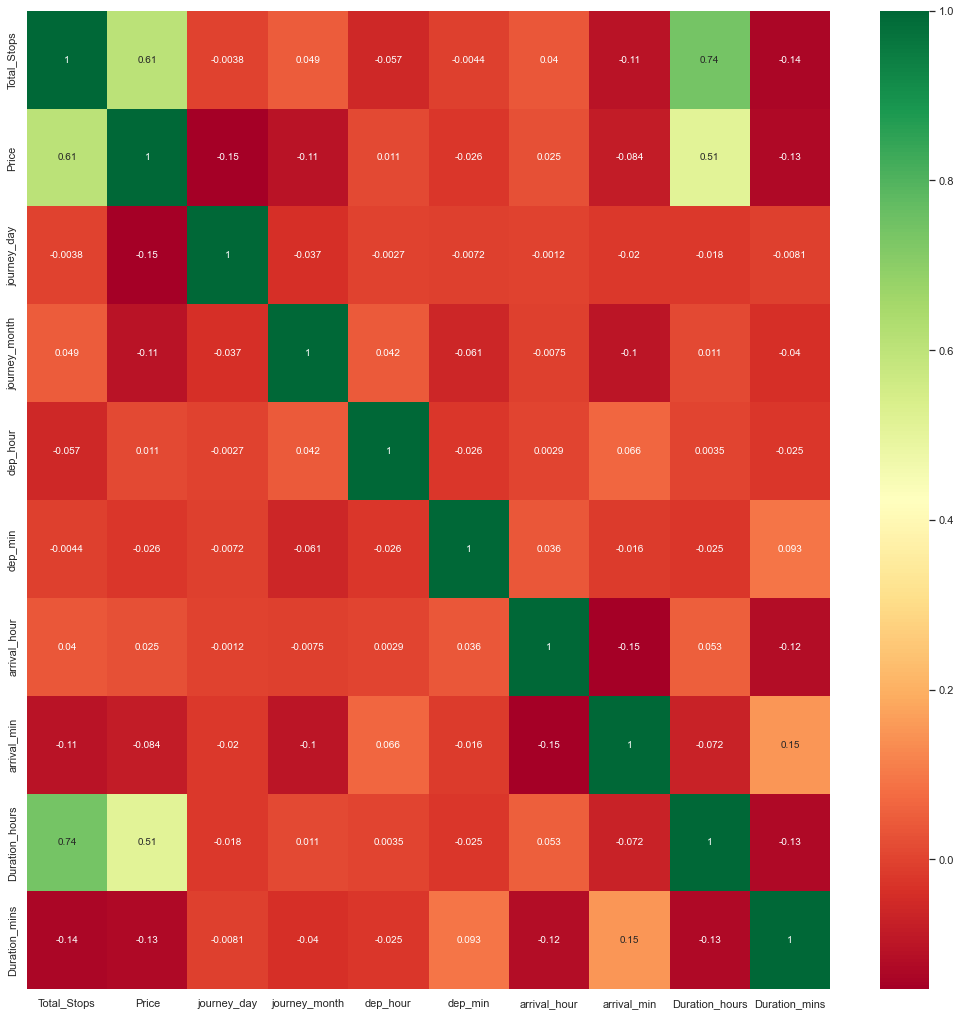

AttributeError: 'function' object has no attribute 'savefig'

In [28]:
plt.figure(figsize = (18,18))
sns.heatmap(dataset.corr(), annot = True, cmap = 'RdYlGn')
fig = plt.gcf
plt.show()
fig.savefig('heatmapfig.pdf')


### feature_importance_

In [34]:
from sklearn.ensemble import RandomForestRegressor
selection = RandomForestRegressor()
selection.fit(X, y)

print(selection.feature_importances_)

[0.03156882 0.1468087  0.06533668 0.03248987 0.02487138 0.0392043
 0.02444219 0.45016257 0.02254918 0.00328021 0.00082968 0.00396908
 0.05269635 0.01773204 0.03360985 0.00256583 0.00219085 0.00060904
 0.00701099 0.00829984 0.00481484 0.00519578 0.01475815 0.00342727
 0.00157649]


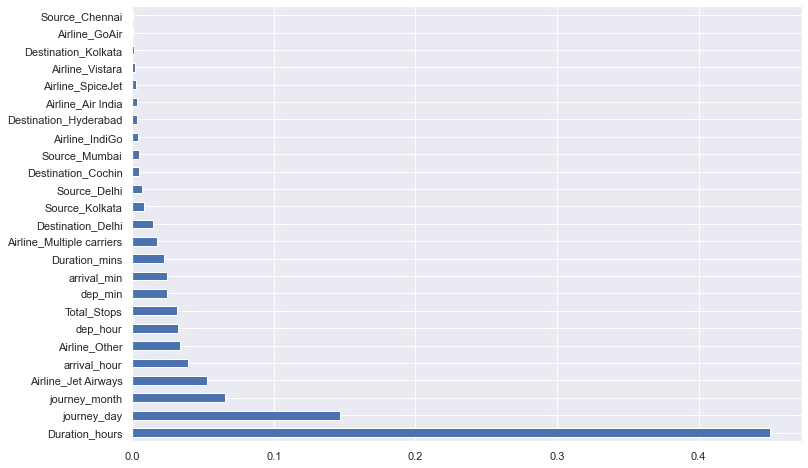

<Figure size 432x288 with 0 Axes>

In [35]:
plt.figure(figsize = (12,8))
feat_importances = pd.Series(selection.feature_importances_, index=X.columns)
feat_importances.nlargest(25).plot(kind='barh')
plt.show()
plt.savefig('featureimportancefig.jpg')

In [ ]:
X = data_train.loc[:, ['Total_Stops', 'journey_day', 'journey_month', 'dep_hour',
       'dep_min', 'arrival_hour', 'arrival_min', 'Duration_hours',
       'Duration_mins', 'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo',
       'Airline_Jet Airways', 'Airline_Multiple carriers', 'Airline_Other',
       'Airline_SpiceJet', 'Airline_Vistara', 'Source_Chennai',
       'Source_Kolkata', 'Source_Mumbai', 'Destination_Cochin',
       'Destination_Delhi', 'Destination_Hyderabad', 'Destination_Kolkata']]
X.head()

,Total_Stops,journey_day,journey_month,dep_hour,dep_min,arrival_hour,arrival_min,Duration_hours,Duration_mins,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Multiple carriers,Airline_Other,Airline_SpiceJet,Airline_Vistara,Source_Chennai,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata
0,0,24,3,22,20,1,10,2,50,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,2,1,5,5,50,13,15,7,25,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,2,9,6,9,25,4,25,19,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
3,1,12,5,18,5,23,30,5,25,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
4,1,1,3,16,50,21,35,4,45,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


## Fit model 


In [37]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


rf_reg = RandomForestRegressor()
rf_reg.fit(X_train, y_train)
print('Model Performance on Training Set:', round(rf_reg.score(X_train, y_train)*100,2))
print('Model Performance on Test Set:', round(rf_reg.score(X_test, y_test)*100,2))

Model Performance on Training Set: 95.46
Model Performance on Test Set: 82.76


### Perfomance of Model

Model Performance on Training Set: 95.46
Model Performance on Test Set: 82.76


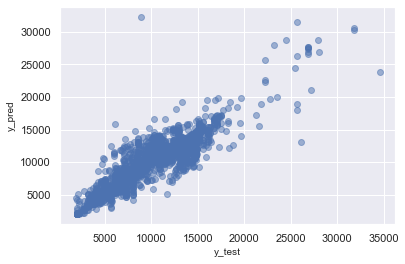

In [38]:
print('Model Performance on Training Set:', round(rf_reg.score(X_train, y_train)*100,2))
print('Model Performance on Test Set:', round(rf_reg.score(X_test, y_test)*100,2))

y_pred = rf_reg.predict(X_test)
plt.scatter(y_test, y_pred, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

#fig.savefig('performancescatterplotfig.pdf')

### RMSE Calculation 

In [40]:
print('R2 value: ', round(metrics.r2_score(y_test, y_pred),4))
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
#RMSE = sqrt((PV-OV)^2/n)
fig.savefig('beforetuningfig.pdf')

R2 value:  0.8276
MAE: 1176.59528819185
MSE: 3424743.022345097
RMSE: 1850.6061229621762


AttributeError: 'function' object has no attribute 'savefig'

## Hyperparameter Tuning
    
    RandomizedSearchCV

In [36]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]

max_features = ['auto', 'sqrt']

max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]

min_samples_split = [2, 5, 10, 15, 100]

min_samples_leaf = [1, 2, 5, 10]

In [42]:
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [43]:
rf_random = RandomizedSearchCV(estimator = rf_reg, param_distributions = random_grid,
                               scoring='neg_mean_squared_error', n_iter = 10, cv = 5, 
                               verbose=2, random_state=42, n_jobs = 1)

## Model Train

In [44]:

rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   4.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   4.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   3.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   3.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   3.8s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1100; total time=   6.0s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1100; total time=   7.0s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimator

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

## Model Test

In [45]:
rf_random.best_params_

{'n_estimators': 700,
 'min_samples_split': 15,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 20}

C:\Users\abhie\AppData\Local\Temp\ipykernel_16312\4012051842.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test-prediction)


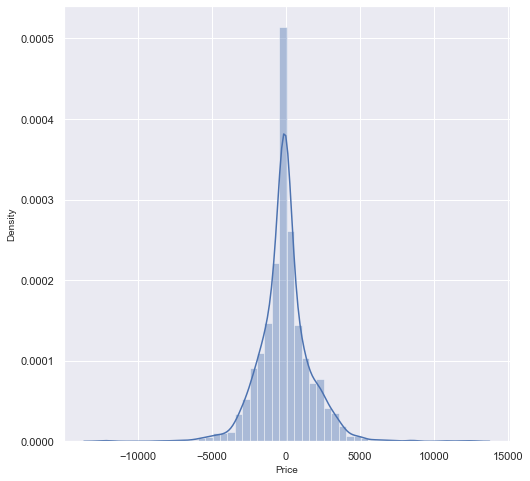

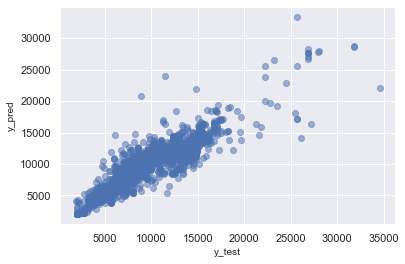

In [46]:
prediction = rf_random.predict(X_test)
plt.figure(figsize = (8,8))
sns.distplot(y_test-prediction)
plt.show()
plt.scatter(y_test, prediction, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

In [57]:
print('R2 value: ', round(metrics.r2_score(y_test, prediction),4))
print('MAE:', metrics.mean_absolute_error(y_test, prediction))
print('MSE:', metrics.mean_squared_error(y_test,prediction))
print('RMSE: ', round(np.sqrt(metrics.mean_squared_error(y_test, prediction)),2))
print('Normalized RMSE: ', round(np.sqrt(metrics.mean_squared_error(y_test, prediction))/(max(y_test)-min(y_test)),2))
print('Max Value: ', max(y_test), '\nMin Value: ', min(y_test))

R2 value:  0.8412
MAE: 1186.7990625606924
MSE: 3154473.1006076117
RMSE:  1776.08
Normalized RMSE:  0.05
Max Value:  34608 
Min Value:  1840


## Model Save

In [48]:
import pickle

In [ ]:
model = open('./Model/flight_price_rf.pkl', 'wb')

pickle.dump(rf_random, model)



In [49]:

path = './Model/flight_price_rf.pkl'
model = open(path, 'rb')
rf_model = pickle.load(model)

In [50]:
unseen_dataset = pd.read_excel("C:\\Users\\abhie\Desktop\\airline-price-prediction\\DataSets\\a2_Unseen_Dataset.xlsx")
unseen_dataset.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,Jet Airways,27/05/2019,Delhi,Cochin,DEL → BOM → COK,07:05,19:00,11h 55m,1 stop,In-flight meal not included,12898.0
1,IndiGo,6/03/2019,Delhi,Cochin,DEL → MAA → COK,02:05,07:25,5h 20m,1 stop,No info,10851.0
2,Air India,21/03/2019,Delhi,Cochin,DEL → BLR → COK,09:45,23:00,13h 15m,1 stop,No info,5704.0
3,Vistara,18/03/2019,Banglore,New Delhi,BLR → DEL,21:10,00:05 16 Mar,2h 55m,non-stop,No info,11598.0
4,Multiple carriers,27/05/2019,Delhi,Cochin,DEL → BOM → COK,08:30,19:15,10h 45m,1 stop,No info,9149.0


In [51]:

unseen_dataset["journey_day"] = pd.to_datetime(unseen_dataset.Date_of_Journey, format="%d/%m/%Y").dt.day
unseen_dataset["journey_month"] = pd.to_datetime(unseen_dataset["Date_of_Journey"], format = "%d/%m/%Y").dt.month
unseen_dataset.drop(["Date_of_Journey"], axis = 1, inplace = True)


unseen_dataset["dep_hour"] = pd.to_datetime(unseen_dataset["Dep_Time"]).dt.hour
unseen_dataset["dep_min"] = pd.to_datetime(unseen_dataset["Dep_Time"]).dt.minute
unseen_dataset.drop(["Dep_Time"], axis = 1, inplace = True)


unseen_dataset["arrival_hour"] = pd.to_datetime(unseen_dataset["Arrival_Time"]).dt.hour
unseen_dataset["arrival_min"] = pd.to_datetime(unseen_dataset["Arrival_Time"]).dt.minute
unseen_dataset.drop(["Arrival_Time"], axis = 1, inplace = True)

duration = list(unseen_dataset["Duration"])
for i in range(len(duration)):
    if len(duration[i].split()) != 2: 
        if "h" in duration[i]:
            duration[i] = duration[i].strip() + " 0m"   
        else:
            duration[i] = "0h " + duration[i]
duration_hours = []
duration_mins = []
for i in range(len(duration)):
    duration_hours.append(int(duration[i].split(sep = "h")[0]))  
    duration_mins.append(int(duration[i].split(sep = "m")[0].split()[-1]))
unseen_dataset["Duration_hours"] = duration_hours
unseen_dataset["Duration_mins"] = duration_mins
unseen_dataset.drop(["Duration"], axis = 1, inplace = True)


Airline = unseen_dataset[["Airline"]]
New_Airline_List = []
Current_Airline_List = Airline['Airline']
for carrier in Current_Airline_List:
  if carrier in ['IndiGo', 'Air India', 'Jet Airways', 'SpiceJet',
       'Multiple carriers', 'GoAir', 'Vistara', 'Air Asia']:
    New_Airline_List.append(carrier)
  else:
    New_Airline_List.append('Other')
Airline['Airline'] = pd.DataFrame(New_Airline_List)
Airline = pd.get_dummies(Airline, drop_first= True)

Source = unseen_dataset[["Source"]]
Source = pd.get_dummies(Source, drop_first= True)
Source.head()


Destination = unseen_dataset[["Destination"]]
Current_Destination_List = Destination['Destination']
New_Destination_List = []
for value in Current_Destination_List:
  if value in ['New Delhi']:
    New_Destination_List.append('Delhi')
  else:
    New_Destination_List.append(value)
Destination['Destination'] = pd.DataFrame(New_Destination_List)
Destination['Destination'].value_counts()
Destination = pd.get_dummies(Destination, drop_first = True)
Destination.head()


unseen_dataset.drop(["Route", "Additional_Info"], axis = 1, inplace = True)


unseen_dataset.replace({"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}, inplace = True)


data_test = pd.concat([unseen_dataset, Airline, Source, Destination], axis = 1)
data_test.drop(["Airline", "Source", "Destination"], axis = 1, inplace = True)

data_test.head()

C:\Users\abhie\AppData\Local\Temp\ipykernel_16312\3521368038.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Airline['Airline'] = pd.DataFrame(New_Airline_List)
C:\Users\abhie\AppData\Local\Temp\ipykernel_16312\3521368038.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Destination['Destination'] = pd.DataFrame(New_Destination_List)


,Total_Stops,Price,journey_day,journey_month,dep_hour,dep_min,arrival_hour,arrival_min,Duration_hours,Duration_mins,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Multiple carriers,Airline_Other,Airline_SpiceJet,Airline_Vistara,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata
0,1,12898.0,27,5,7,5,19,0,11,55,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0
1,1,10851.0,6,3,2,5,7,25,5,20,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0
2,1,5704.0,21,3,9,45,23,0,13,15,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
3,0,11598.0,18,3,21,10,0,5,2,55,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4,1,9149.0,27,5,8,30,19,15,10,45,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0


In [52]:
X_unseen = data_test.loc[:, ['Total_Stops', 'journey_day', 'journey_month', 'dep_hour',
       'dep_min', 'arrival_hour', 'arrival_min', 'Duration_hours',
       'Duration_mins', 'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo',
       'Airline_Jet Airways', 'Airline_Multiple carriers', 'Airline_Other',
       'Airline_SpiceJet', 'Airline_Vistara', 'Source_Chennai',
       'Source_Kolkata', 'Source_Mumbai', 'Destination_Cochin',
       'Destination_Delhi', 'Destination_Hyderabad', 'Destination_Kolkata']]
y_unseen = data_test.iloc[:, 1]

In [56]:
y_pred = rf_model.predict(X_unseen)

df_y_pred = pd.DataFrame(y_pred,columns= ['Predicted Price'])
original_dataset = pd.read_excel("C:\\Users\\abhie\Desktop\\airline-price-prediction\\DataSets\\a2_Unseen_Dataset.xlsx")
dfx = pd.concat([original_dataset, df_y_pred], axis=1)
dfx.to_excel("./DataSets/c22_ModelOutput.xlsx")
dfx.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Predicted Price
0,Jet Airways,27/05/2019,Delhi,Cochin,DEL → BOM → COK,07:05,19:00,11h 55m,1 stop,In-flight meal not included,12898.0,14361.172504
1,IndiGo,6/03/2019,Delhi,Cochin,DEL → MAA → COK,02:05,07:25,5h 20m,1 stop,No info,10851.0,11687.761728
2,Air India,21/03/2019,Delhi,Cochin,DEL → BLR → COK,09:45,23:00,13h 15m,1 stop,No info,5704.0,6535.501997
3,Vistara,18/03/2019,Banglore,New Delhi,BLR → DEL,21:10,00:05 16 Mar,2h 55m,non-stop,No info,11598.0,5736.721939
4,Multiple carriers,27/05/2019,Delhi,Cochin,DEL → BOM → COK,08:30,19:15,10h 45m,1 stop,No info,9149.0,8666.552530


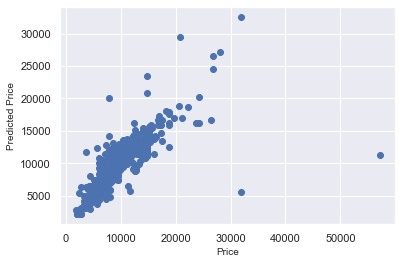

In [55]:
plt.scatter(dfx.Price,y_pred)
plt.xlabel("Price")
plt.ylabel("Predicted Price")
plt.show()